In [16]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import requests

In [17]:
%%capture
%run -i -e Pair_Selection.ipynb

In [18]:
# Print or use the top 10 pairs
print("Top 10 pairs with highest correlation and cointegration:")
for pair in top_10_pairs:
    print(pair)

Top 10 pairs with highest correlation and cointegration:
('AME', 'IEX', 0.9895348210168529, 0.9981550340170154)
('AWK', 'NEE', 0.9868568115394872, 0.9978297037556406)
('NSC', 'UNP', 0.9845398428619785, 0.9962703873569635)
('ES', 'WEC', 0.9805179496276685, 0.9975536613887012)
('IEX', 'TT', 0.9759080920996287, 0.9999009387718026)
('AME', 'TT', 0.9823254205542588, 0.9916906319609196)
('CFG', 'RF', 0.9823147370618126, 0.9861014911475879)
('HSY', 'MDLZ', 0.9747480003810439, 0.9937482692885858)
('BAC', 'PNC', 0.984833159363554, 0.9826067071814256)
('DTE', 'PEG', 0.9673594718837637, 0.9991156230037618)


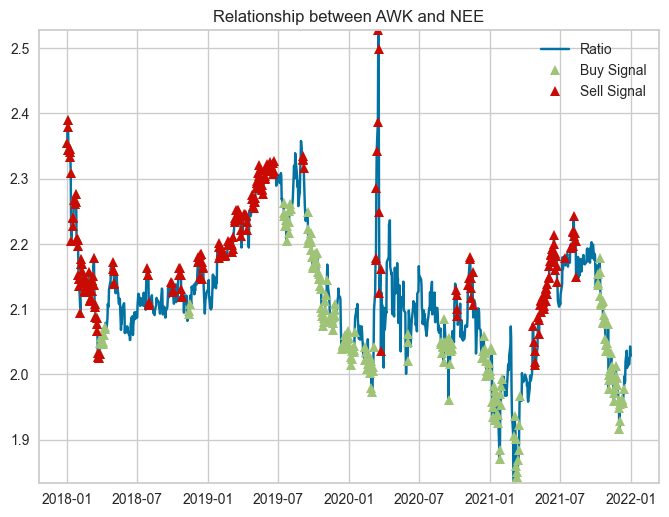

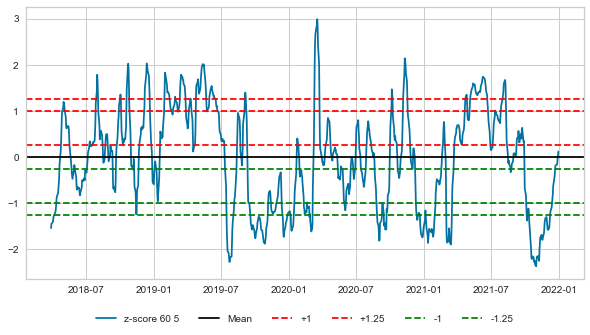

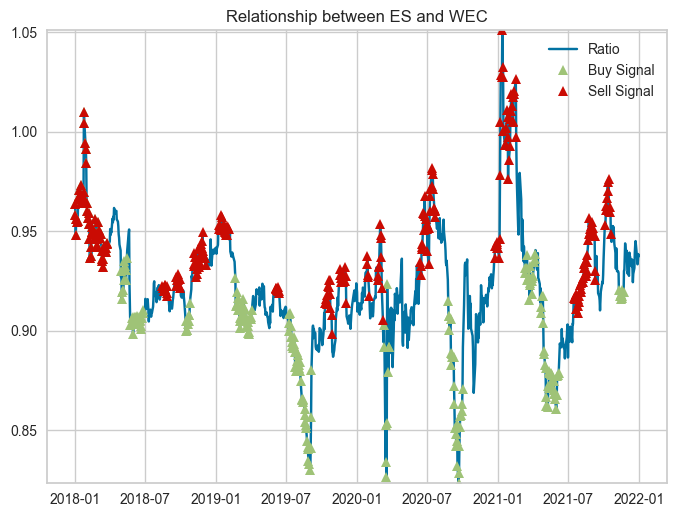

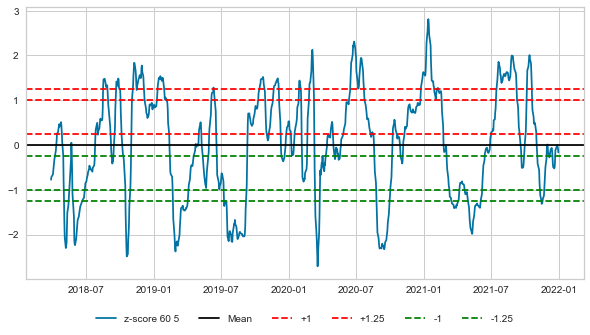

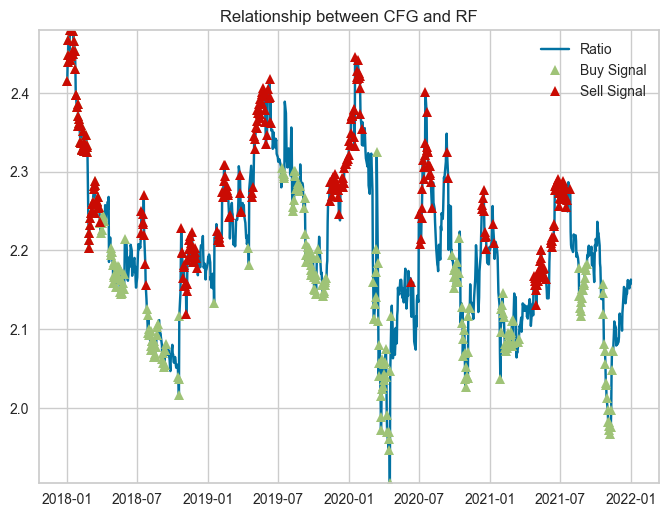

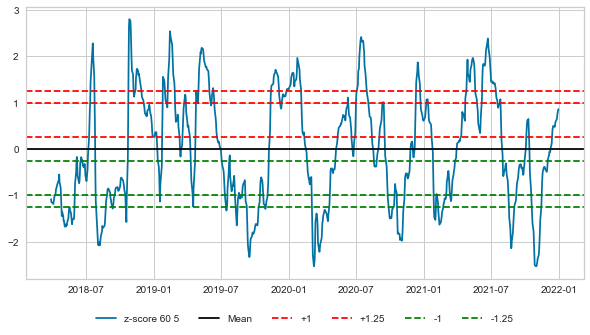

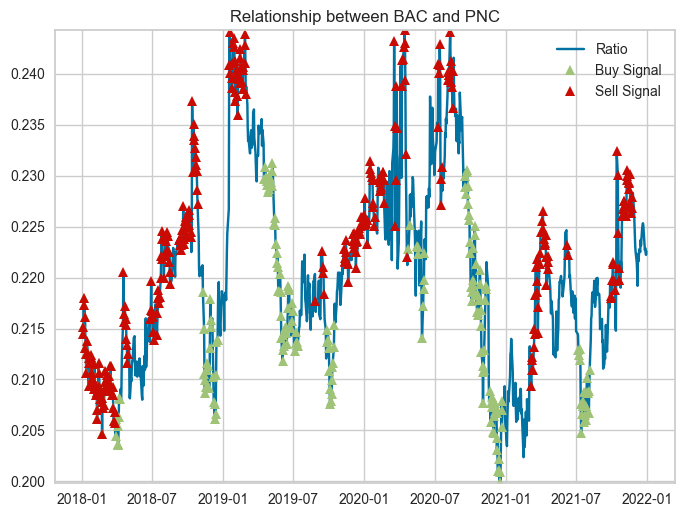

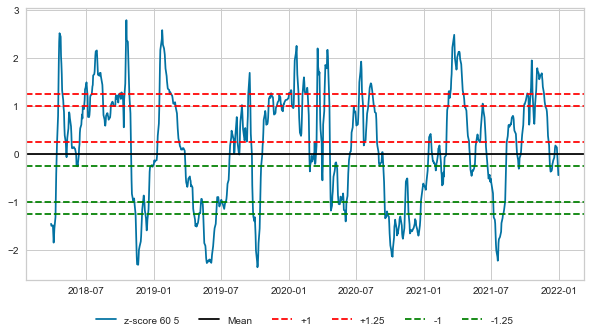

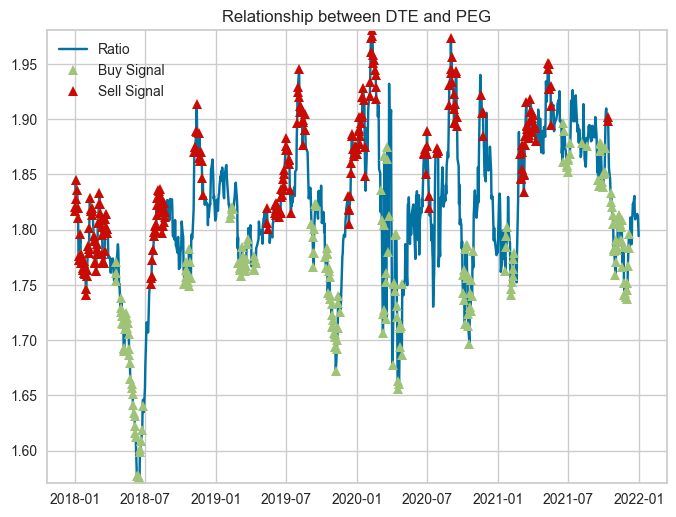

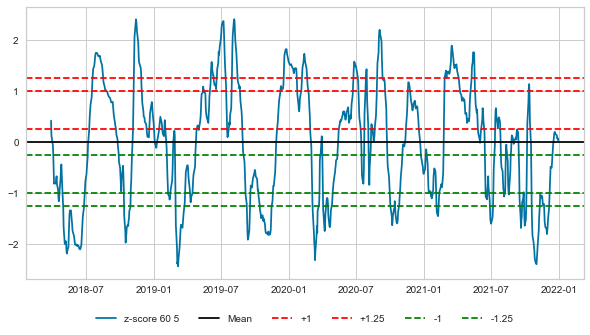

In [19]:
for pair in top_10_pairs:
    # Cointgration test
    stock_1 = data[pair[0]]
    stock_2 = data[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

            plt.figure(figsize=(8, 6), dpi=100)
            plt.plot(ratio)
            buy = ratio.copy()
            sell = ratio.copy()
            buy[zscore_60_5>-1] = np.nan
            sell[zscore_60_5<1] = np.nan

            plt.plot(buy, color='g', linestyle='None', marker='^')
            plt.plot(sell, color='r', linestyle='None', marker='^')

            x1, x2, y1, y2 = plt.axis()
            plt.axis((x1, x2, ratio.min(), ratio.max()))
            plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
            plt.title(f'Relationship between {pair[0]} and {pair[1]}')
            plt.show()


            plt.figure(figsize=(10, 5))
            plt.plot(zscore_60_5)
            plt.axhline(0, color='black')
            plt.axhline(1, color='red', linestyle='--')
            plt.axhline(1.25, color='red', linestyle='--')
            plt.axhline(-1, color='green', linestyle='--')
            plt.axhline(-1.25, color='green', linestyle='--')
            plt.axhline(0.25, color='red', linestyle='--')
            plt.axhline(-0.25, color='green', linestyle='--')
            plt.legend(['z-score 60 5', 'Mean', '+1','+1.25','-1','-1.25'], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
            plt.show()

In [20]:
trading_pairs = top_10_pairs.copy()
print(top_10_pairs)
print(trading_pairs)

[('AME', 'IEX', 0.9895348210168529, 0.9981550340170154), ('AWK', 'NEE', 0.9868568115394872, 0.9978297037556406), ('NSC', 'UNP', 0.9845398428619785, 0.9962703873569635), ('ES', 'WEC', 0.9805179496276685, 0.9975536613887012), ('IEX', 'TT', 0.9759080920996287, 0.9999009387718026), ('AME', 'TT', 0.9823254205542588, 0.9916906319609196), ('CFG', 'RF', 0.9823147370618126, 0.9861014911475879), ('HSY', 'MDLZ', 0.9747480003810439, 0.9937482692885858), ('BAC', 'PNC', 0.984833159363554, 0.9826067071814256), ('DTE', 'PEG', 0.9673594718837637, 0.9991156230037618)]
[('AME', 'IEX', 0.9895348210168529, 0.9981550340170154), ('AWK', 'NEE', 0.9868568115394872, 0.9978297037556406), ('NSC', 'UNP', 0.9845398428619785, 0.9962703873569635), ('ES', 'WEC', 0.9805179496276685, 0.9975536613887012), ('IEX', 'TT', 0.9759080920996287, 0.9999009387718026), ('AME', 'TT', 0.9823254205542588, 0.9916906319609196), ('CFG', 'RF', 0.9823147370618126, 0.9861014911475879), ('HSY', 'MDLZ', 0.9747480003810439, 0.9937482692885858

In [26]:
# Trading strategy
total_profit = 0
total_trade_vol = 0
total_order_fees = 0
transaction_list = []
trade_profit_list = []
number_of_trading_days = len(zscore_60_5) - 1
for pair in trading_pairs:
    # Cointgration test
    stock_1 = data[pair[0]]
    stock_2 = data[pair[1]]
    result = ts.coint(stock_1, stock_2)
    
    cointegration_t_statistic = result[0]
    p_val = result[1]
    critical_values_test_statistic_at_1_5_10 = result[2]
    
    if p_val < 0.05:
        # Dickey-Fuller Test
        first_ADF = adfuller(stock_1)
        second_ADF = adfuller(stock_2)
        Spread_ADF = adfuller(stock_1 - stock_2)
        Ratio_ADF = adfuller(stock_1 / stock_2)
        
        ratio, min_ratio = None, None

        if Spread_ADF[1] < Ratio_ADF[1]:
            ratio = stock_1 - stock_2
            min_ratio = Spread_ADF[1]
        elif Spread_ADF[1] > Ratio_ADF[1]:
            ratio = stock_1 / stock_2
            min_ratio = Ratio_ADF[1]

        if min_ratio < 0.05:
            # Create a signals
            ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
            ratios_mavg60 = ratio.rolling(window=60, center=False).mean()

            std_60 = ratio.rolling(window=60, center=False).std()
            zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60


            # only trade pairs with p-value < 0.05
            trade_volume = 1000
            first_trade_day = 0 
            quant_1, quant_2 = 0, 0
            spec_amount_1, spec_amount_2 = 0, 0
            not_invested_1, not_invested_2 = 0, 0
            trade_sum = 0
            profit = 0
            trade_profit = 0
            # buy signals
            for day, zscore_value in enumerate(zscore_60_5):    
                if zscore_value < -1 and first_trade_day == 0: # long stock_1 and short stock_2 + get first trading day
                    quant_1 += (trade_volume/2) // stock_1.iloc[day]
                    spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                    quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                    spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                    if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                        not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_1 * 0.0025 + 7.5
                    if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                        not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_2 * 0.0025 + 7.5
                    not_invested_1 += trade_volume % stock_1.iloc[day]
                    not_invested_2 += trade_volume % stock_2.iloc[day]
                    trade_sum += trade_volume
                    first_trade_day = day
                    total_trade_vol += trade_volume
                    transaction_list.append((first_trade_day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day]))
                    continue
                    #list.append('day + quant1, quant2, stock_1.iloc, tradesum etc.') # Bei Verkauf dann auch stock_1.iloc und day etc. und Rendite berechnen wenn es geht
                    #print(first_trade_day)
                    #print(quant_1, trade_sum, zscore_value, day)

                if zscore_value < -1: # long stock_1 and short stock_2
                    quant_1 += (trade_volume/2) // stock_1.iloc[day]
                    spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                    quant_2 += - (trade_volume/2) // stock_2.iloc[day]
                    spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                    if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                        not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_1 * 0.0025 + 7.5
                    if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                        not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_2 * 0.0025 + 7.5
                    not_invested_1 += trade_volume % stock_1.iloc[day]
                    not_invested_2 += trade_volume % stock_2.iloc[day]
                    trade_sum += trade_volume
                    total_trade_vol += trade_volume
                    #print(quant_1, trade_sum, zscore_value, day)

                if zscore_value > -0.25: # close trades
                    amount_1 = quant_1 * stock_1.iloc[day]
                    amount_2 = - quant_2 * stock_2.iloc[day]
                    if quant_1 > 0: # Order fees
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))

                    # reset values for building up next trade
                    quant_1 = 0
                    quant_2 = 0
                    spec_amount_1 = 0
                    spec_amount_2 = 0
                    not_invested_1 = 0
                    not_invested_2 = 0
                    first_trade_day = 0
                    trade_sum = 0
                    trade_profit = 0
            
                if zscore_value < -3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore -> risk management
                    amount_1 = quant_1 * stock_1.iloc[day]
                    amount_2 = - quant_2 * stock_2.iloc[day]
                    if quant_1 > 0: # Order fees
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))

                    print("risk mgmt, buy, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                    trading_pairs.remove(pair)
                    break

                expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
                if day == expiration_day and zscore_value < -1 : # close trades because it will take more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                    amount_1 = quant_1 * stock_1.iloc[day]
                    amount_2 = - quant_2 * stock_2.iloc[day]
                    if quant_1 > 0: # Order fees
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))

                    print("risk mgmt, buy, max. holding period, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                    trading_pairs.remove(pair)
                    break

                if day == number_of_trading_days: # close open trades on the last day
                    amount_1 = quant_1 * stock_1.iloc[day]
                    amount_2 = - quant_2 * stock_2.iloc[day]
                    if quant_1 > 0: # Order fees
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 < 0: # Order fees, quant_2 < 0 because we are shorting stock_2
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_1 > 0 or quant_2 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))

            # reset values for sell signals
            first_trade_day = 0 
            quant_1, quant_2 = 0, 0
            spec_amount_1, spec_amount_2 = 0, 0
            not_invested_1, not_invested_2 = 0, 0
            trade_sum = 0
            trade_profit = 0
            # sell signals
            for day, zscore_value in enumerate(zscore_60_5):    
                if zscore_value > 1 and first_trade_day == 0: # short stock_1 and long stock_2 + get first trading day
                    quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                    spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                    quant_2 += (trade_volume/2) // stock_2.iloc[day]
                    spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                    if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                        not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_1 * 0.0025 + 7.5
                    if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                        not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_2 * 0.0025 + 7.5
                    not_invested_1 += trade_volume % stock_1.iloc[day]
                    not_invested_2 += trade_volume % stock_2.iloc[day]
                    trade_sum += trade_volume
                    first_trade_day = day
                    total_trade_vol += trade_volume
                    transaction_list.append((first_trade_day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day]))
                    continue
                    #print(first_trade_day)
                    #print(quant_1, trade_sum, zscore_value, day)

                if zscore_value > 1: # short stock_1 and long stock_2
                    quant_1 += - (trade_volume/2) // stock_1.iloc[day]
                    spec_amount_1 = ((trade_volume/2) // stock_1.iloc[day]) * stock_1.iloc[day]
                    quant_2 += (trade_volume/2) // stock_2.iloc[day]
                    spec_amount_2 = ((trade_volume/2) // stock_2.iloc[day]) * stock_2.iloc[day]
                    if ((trade_volume/2) // stock_1.iloc[day]) > 0: # Order fees
                        not_invested_1 -= spec_amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_1 * 0.0025 + 7.5
                    if ((trade_volume/2) // stock_2.iloc[day]) > 0: # Order fees
                        not_invested_2 -= spec_amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += spec_amount_2 * 0.0025 + 7.5
                    not_invested_1 += trade_volume % stock_1.iloc[day]
                    not_invested_2 += trade_volume % stock_2.iloc[day]
                    trade_sum += trade_volume
                    total_trade_vol += trade_volume
                    #print(quant_1, trade_sum, zscore_value, day)

                if zscore_value < 0.25: # close trades
                    amount_1 = - quant_1 * stock_1.iloc[day]
                    amount_2 = quant_2 * stock_2.iloc[day]
                    if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 > 0: # Order fees
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum                
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))

                    # reset values for building up next trade
                    quant_1 = 0
                    quant_2 = 0
                    spec_amount_1 = 0
                    spec_amount_2 = 0
                    not_invested_1 = 0
                    not_invested_2 = 0
                    first_trade_day = 0
                    trade_sum = 0
                    trade_profit = 0
            
                if zscore_value > 3: # close trades, because z-score is to big and correlation doesnt seem to exist anymore
                    amount_1 = - quant_1 * stock_1.iloc[day]
                    amount_2 = quant_2 * stock_2.iloc[day]
                    if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 > 0: # Order fees
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum 
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))
                    
                    print("risk mgmt, sell, z-score is to big, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                    trading_pairs.remove(pair)
                    break

                expiration_day = first_trade_day + 126 # change value for max. holding period of one week, month or quarter 
                if day == expiration_day and zscore_value > 1 : # close trades, since it took more than half a year since first trade to close z-score gap -> risk management to protect against potential loss of correlation 
                    amount_1 = - quant_1 * stock_1.iloc[day]
                    amount_2 = quant_2 * stock_2.iloc[day]
                    if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 > 0: # Order fees
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))
                    
                    print("risk mgmt, sell, max. holding period, the pair", pair[0], "&", pair[1], "will be removed. The profit before removal is:")
                    trading_pairs.remove(pair)
                    break

                if day == number_of_trading_days: # close open trades on the last day
                    amount_1 = - quant_1 * stock_1.iloc[day]
                    amount_2 = quant_2 * stock_2.iloc[day]
                    if quant_1 < 0: # Order fees, quant_1 < 0 because we are shorting stock_1
                        not_invested_1 -= amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_1 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                    if quant_2 > 0: # Order fees
                        not_invested_2 -= amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees
                        total_order_fees += amount_2 * 0.0025 + 7.5 # assume 7.50 + 0.25% order fees

                    trade_profit = amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum
                    profit += amount_1 + amount_2 + not_invested_1 + not_invested_2 - trade_sum

                    if quant_2 > 0 or quant_1 < 0: # Append closed trade to list
                        transaction_list.append((day, pair[0], stock_1.iloc[day], pair[1], stock_2.iloc[day], trade_sum, trade_profit, profit))
                        trade_profit_list.append((trade_sum, trade_profit))

        else:
            continue
    
    total_profit += profit
    total_profit_after_tax = total_profit * 0.73625 # 26.375% capital gains tax & solidarity surcharge

    print("Stock 1:", pair[0], "| Stock 2:", pair[1], "| Profit in Dollar before taxes:", round(profit,2))
print("Total profit in Dollar after taxes:", round(total_profit_after_tax,2))
print("Total order fees:", round(total_order_fees,2))
print("Total trade volume:", total_trade_vol)
#transaction_list
#trade_profit_list
    

Stock 1: AWK | Stock 2: NEE | Profit in Dollar before taxes: 48069.79
Stock 1: ES | Stock 2: WEC | Profit in Dollar before taxes: 29361.32
Stock 1: CFG | Stock 2: RF | Profit in Dollar before taxes: 9215.73
Stock 1: BAC | Stock 2: PNC | Profit in Dollar before taxes: 39443.55
Stock 1: DTE | Stock 2: PEG | Profit in Dollar before taxes: 25505.13
Total profit in Dollar after taxes: 111612.2
Total order fees: 46214.31
Total trade volume: 2243000


In [27]:
# transaction history
transaction = transaction_list.copy()
df = pd.DataFrame(transaction)
df.columns = ['day', 'stock 1', 'price stock 1', 'stock 2', 'price stock 2', 'trade sum', 'trade profit', 'total profit per pair']
df = df.fillna(0)
df['open/close'] = df['trade sum'].apply(lambda x: 'open' if x == 0 else 'close')
df = df[['open/close'] + [col for col in df.columns if col != 'open/close']]
trade_sum_check = df['trade sum'].sum()
print(trade_sum_check)
df
#df.head(80)

2243000.0


,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,open,59,AWK,75.569229,NEE,36.905239,0.0,0.000000,0.000000
1,close,75,AWK,77.877525,NEE,36.568634,9000.0,-180.950214,-180.950214
2,open,219,AWK,86.174614,NEE,41.179283,0.0,0.000000,0.000000
3,close,224,AWK,87.952194,NEE,41.204647,3000.0,48.776784,-132.173429
4,open,385,AWK,110.495125,NEE,48.844002,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
215,close,748,DTE,96.227325,PEG,53.750011,4000.0,10.979566,20399.412030
216,open,793,DTE,95.723183,PEG,51.237167,0.0,0.000000,0.000000
217,close,857,DTE,113.180984,PEG,59.668766,37000.0,4953.947625,25353.359655
218,open,951,DTE,110.369385,PEG,58.015678,0.0,0.000000,0.000000


In [28]:
# profit history
avg_profit = trade_profit_list.copy()
data = pd.DataFrame(avg_profit)
data.columns = ['trade sum', 'trade profit before taxes']
#print(data.isnull().any())
data['trade profit after taxes'] = data['trade profit before taxes'] * 0.73625
data['trade return before taxes'] = data['trade profit before taxes'] / data ['trade sum']
data['trade return after taxes'] = data['trade profit after taxes'] / data ['trade sum']
average_trade_profit_before_taxes = data['trade profit before taxes'].mean()
average_trade_profit_after_taxes = data['trade profit after taxes'].mean()
average_trade_return_before_taxes = data['trade return before taxes'].mean()
average_trade_return_after_taxes = data['trade return after taxes'].mean()
#total_profit_check = data['trade profit before taxes'].sum()
#print(total_profit_check)
#total_profit_check2 = data['trade profit after taxes'].sum()
#print(total_profit_check2)
trade_sum_check = data['trade sum'].sum()
print(trade_sum_check)
average_trade_return_before_taxes = round(average_trade_return_before_taxes * 100,2)
average_trade_return_after_taxes = round(average_trade_return_after_taxes * 100,2)
print("Average trade profit before taxes:", average_trade_profit_before_taxes)
print("Average trade profit after taxes:", average_trade_profit_after_taxes) # Man könnte noch Verlustverrechnung betrachten (Erwähnen in Nebensatz in Hausarbeit)
print("Average trade return before taxes:", average_trade_return_before_taxes, "%")
print("Average trade return after taxes:", average_trade_return_after_taxes, "%")
data
#data.head(51)

2243000
Average trade profit before taxes: 1378.1410328986105
Average trade profit after taxes: 1014.6563354716017
Average trade return before taxes: 5.67 %
Average trade return after taxes: 4.18 %


,trade sum,trade profit before taxes,trade profit after taxes,trade return before taxes,trade return after taxes
0,9000,-180.950214,-133.224595,-0.020106,-0.014803
1,3000,48.776784,35.911908,0.016259,0.011971
2,15000,751.937762,553.614177,0.050129,0.036908
3,70000,12129.125836,8930.068897,0.173273,0.127572
4,16000,68.577100,50.489890,0.004286,0.003156
...,...,...,...,...,...
105,4000,624.512430,459.797276,0.156128,0.114949
106,15000,1282.147164,943.980850,0.085476,0.062932
107,4000,10.979566,8.083706,0.002745,0.002021
108,37000,4953.947625,3647.343939,0.133890,0.098577


In [29]:
negative_profit_rows = df[df['trade profit'] < 0]
open_trade_indices = negative_profit_rows.index - 1
open_trade_rows = df.loc[open_trade_indices]
result_df = pd.concat([open_trade_rows, negative_profit_rows])
result_df = result_df.sort_index()
result_df_sorted = result_df.reset_index(drop=True)
result_df_sorted
#result_df_sorted.head(50)

,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,open,59,AWK,75.569229,NEE,36.905239,0.0,0.000000,0.000000
1,close,75,AWK,77.877525,NEE,36.568634,9000.0,-180.950214,-180.950214
2,open,59,CFG,35.106281,RF,15.706021,0.0,0.000000,0.000000
3,close,106,CFG,35.242458,RF,16.006739,34000.0,-314.415445,-314.415445
4,open,143,CFG,34.061768,RF,16.021500,0.0,0.000000,0.000000
5,close,203,CFG,30.589903,RF,14.248387,33000.0,-3847.563368,-4161.978812
6,open,262,CFG,29.208797,RF,13.693273,0.0,0.000000,0.000000
7,close,265,CFG,30.113497,RF,13.482739,1000.0,-16.917953,-4178.896766
8,open,956,CFG,47.852745,RF,22.296589,0.0,0.000000,0.000000
9,close,988,CFG,45.545689,RF,21.563187,20000.0,-1179.015127,10108.762595


In [30]:
negative_values = df[df['trade profit'] < 0]
negative_values_reset = negative_values.reset_index(drop=True)
negative_values_reset

,open/close,day,stock 1,price stock 1,stock 2,price stock 2,trade sum,trade profit,total profit per pair
0,close,75,AWK,77.877525,NEE,36.568634,9000.0,-180.950214,-180.950214
1,close,106,CFG,35.242458,RF,16.006739,34000.0,-314.415445,-314.415445
2,close,203,CFG,30.589903,RF,14.248387,33000.0,-3847.563368,-4161.978812
3,close,265,CFG,30.113497,RF,13.482739,1000.0,-16.917953,-4178.896766
4,close,988,CFG,45.545689,RF,21.563187,20000.0,-1179.015127,10108.762595
5,close,256,CFG,27.942221,RF,12.895009,28000.0,-2642.333843,7653.883724
6,close,298,CFG,30.486607,RF,13.824777,19000.0,-25.577252,7628.306473
7,close,620,CFG,23.319942,RF,11.203826,1000.0,-124.693669,9021.819823
8,close,900,CFG,41.089035,RF,18.649633,53000.0,-3161.543219,9215.731823
9,close,247,BAC,22.286406,PNC,102.631172,23000.0,-319.585613,514.130973


In [31]:
check_negative_values = data[data['trade profit before taxes'] < 0]
check_negative_values_reset = check_negative_values.reset_index(drop=True)
check_negative_values_reset

,trade sum,trade profit before taxes,trade profit after taxes,trade return before taxes,trade return after taxes
0,9000,-180.950214,-133.224595,-0.020106,-0.014803
1,34000,-314.415445,-231.488371,-0.009248,-0.006808
2,33000,-3847.563368,-2832.768530,-0.116593,-0.085841
3,1000,-16.917953,-12.455843,-0.016918,-0.012456
4,20000,-1179.015127,-868.049887,-0.058951,-0.043402
5,28000,-2642.333843,-1945.418292,-0.094369,-0.069479
6,19000,-25.577252,-18.831252,-0.001346,-0.000991
7,1000,-124.693669,-91.805714,-0.124694,-0.091806
8,53000,-3161.543219,-2327.686195,-0.059652,-0.043919
9,23000,-319.585613,-235.294908,-0.013895,-0.010230
